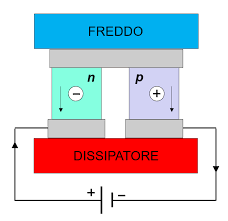

In [6]:
from IPython.display import Image, display

images = [
    Image("Media/Cella di Pelteir.png")
]
display(*images)

## Celle di Peltier

### Configurazione della lettura seriale PR59
- Abbiamo usato la libreria "pyserial" con modulo "Serial"

- Abbiamo overclocckato la priorità usando il modulo "psutil.Process" perchè ci siamo accorti che abbassando la finestra dell'output di python cambiasse la priorità che il sistema dedicasse al programma, con conseguenza che aumentasse la frequenza di correzione della temperatura del PID e questo non lo volevamo

- Abbiamo modificato il programma per renderlo disponibile ad accettare comandi durante l'esecuzione del programma

----
### Strumenti e ciclo di misura

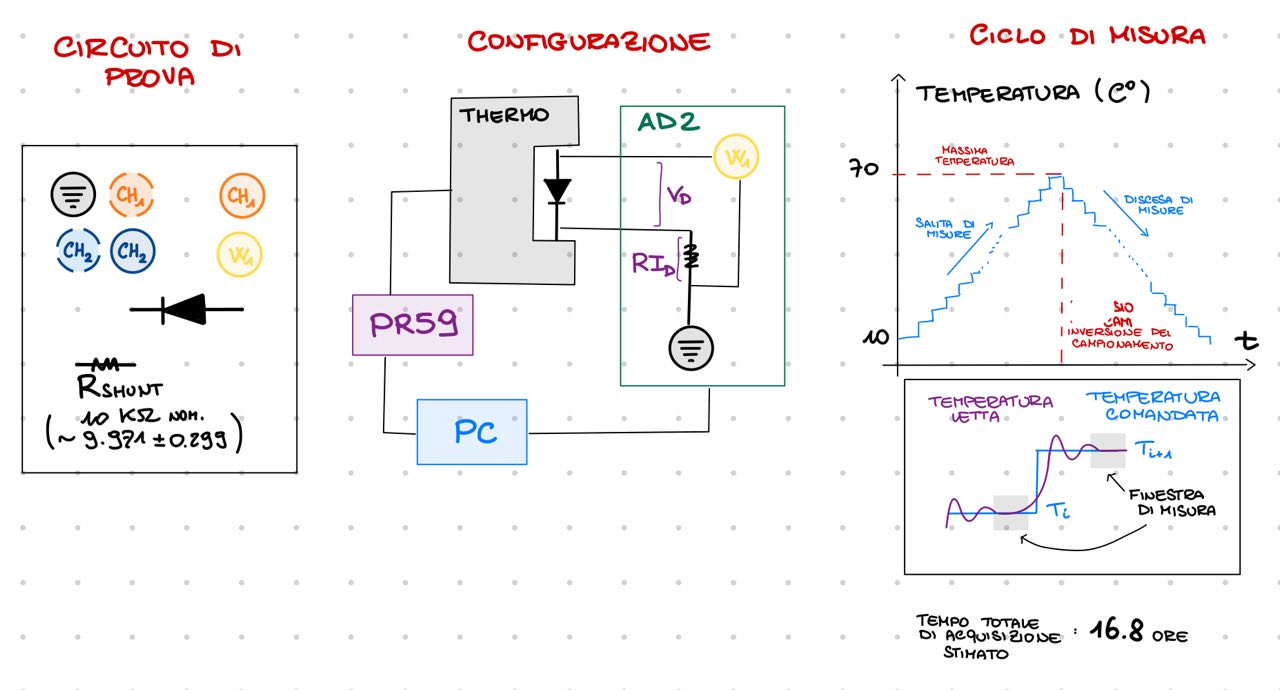

In [9]:
images = [
    Image("Media/Framework.jpg",width=900)
]
display(*images)

$R_{shunt}=9.971 \pm 0.299 k\Omega$

Descrizione del ciclo di misura
- Per ogni temperatura vengono effettuati due sweep in tensione $V_{go}$ e $V_{return}$
- Vengono effettuati un ciclo di temperatura di salita e di discesa

-----
### Risposta del diodo al variare della temperatura
Vorremmo fittare la seguente funzione:

$\boxed{I_d = I_s\left[ e^{\frac{eV}{\eta k_B T}}-1\right]}$ con in generale una corrente di saturazione $\boxed{I_s = I_0 T^\gamma e^{\frac{E_0}{\eta k_B T}}}$:

- $\text{\textbf{Modello di Shockley}}$: per un diodo bipolare consideriamo:
    - Esponente: $\gamma = \frac{3}{2}$, 
    - Energia di ground state: $E_0 \approx 1.1 eV$, 
    - Fattore di idealità: $\eta \in [1,2]$

- $\text{\textbf{Modello di Richardson}}$: per un diodo unipolare consideriamo:
    - Esponente: $\gamma = 2$, 
    - Altezza della barriera Schottky: $E_0$, 
    - Fattore di idealità: $\eta =1$

$\text{\textbf{Modello Zener}}$: per un diodo zener consideriamo:

$\boxed{I(V, T) \approx
\begin{cases}
I_s(T) \left( e^{\frac{qV}{n k T}} - 1 \right) & \text{se}\quad V > 0 \\
-I_s(T) \left( e^{\frac{-q(V + V_Z(T))}{n k T}} - 1 \right) & \text{se}\quad  V < -V_Z(T) \\
I_\text{leak}(T) & \text{se}\quad  -V_Z(T) < V < 0
\end{cases}}$

con:
- $\boxed{I_s(T) = I_0 T^2 e^{\frac{-E_g}{k_B T}} }$ (comportamento Schottky)

- $\boxed{V_Z(T) = V_Z(T_0) + \Delta V_Z(T-T_0) }$ (voltaggio di soglia comportamento Zener)

- $\boxed{I_{leak}(T) = I_{leak}(T_0) T^2 e^{\frac{-E_g}{k_B T}} }$ con $I_{leak}(T_0)\ll I_0\quad$ (corrente di fuga inversa)

Effettueremo le seguenti scelte:
- Spezziamo i dati dello Zenner nelle tre aree e le fitteremo separatamente
- Fissiamo un valore $T_0\approx 35°$ circa in mezzo all'intervallo di temperatura e trascuriamo $\Delta V_Z(T-T_0)$
- Consideriamo $I_{leak}(T)\approx I_{leak}(T_0)$ data la slope molto bassa

----
### Test del funzionamento del diodo a temperatura fissata
Osserviamo la temperatura $T=25°$ dal controller della temperatura seriale contemporaneamente corrente $I_d$ e tensione $V$ tramite AD2.

/var/folders/q8/5bxz228s2vv15c436kznwm3r0000gn/T/ipykernel_23113/1355689731.py:35: RuntimeWarning: overflow encountered in exp
  Is = A * T_K**(3/2) * np.exp(Eg / (n*k * T_K))
/var/folders/q8/5bxz228s2vv15c436kznwm3r0000gn/T/ipykernel_23113/1355689731.py:48: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(shockley_fit, np.vstack((V_bipolar, np.full_like(V_bipolar, 25))), I_bipolar)


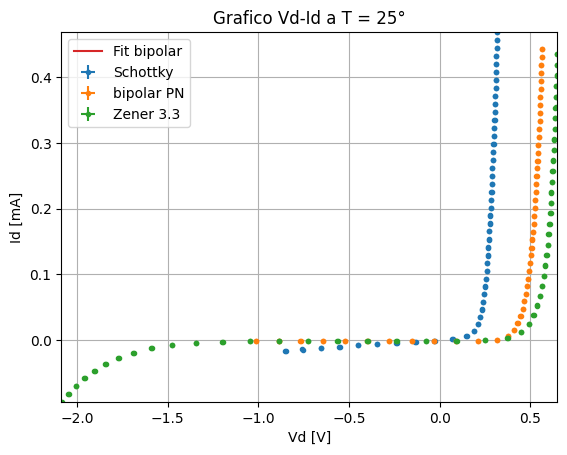

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#%matplotlib widget

# Funzione per caricare e ordinare i dati
def load_and_sort_data(data):
    Td_go, Td_return, Vc, Vd_go, Vd_return, ErrVd_go, ErrVd_return, Vr_go, Vr_return, ErrVr_go, ErrVr_return, Id_go, Id_return, ErrId_go, ErrId_return = data
    V = np.concatenate((Vd_go, Vd_return))
    I = np.concatenate((Id_go, Id_return)) * 1e3  # Conversione a mA
    err_V = np.concatenate((ErrVd_go, ErrVd_return))
    err_I = np.concatenate((ErrId_go, ErrId_return))
    idx = np.argsort(V)
    V = V[idx]
    I = I[idx]
    return V, I, err_V, err_I

# Caricamento dei dati
data_bipolar = np.loadtxt("Data/IV-T_dependence_20250404_100546/IV_T25.00_V-1.00_5.00_0Pull_TGo.txt", unpack=True)
V_bipolar, I_bipolar, dV_bipolar, dI_bipolar = load_and_sort_data(data_bipolar)

data_schottky = np.loadtxt("Data/IV-T_dependence_20250408_110423/IV_T25.00_V-1.00_5.00_0Pull_TGo.txt", unpack=True)
V_schottky, I_schottky, dV_schottky, dI_schottky = load_and_sort_data(data_schottky)

data_zener33 = np.loadtxt("Data/IV-T_dependence_20250408_124236/IV_T25.00_V-3.00_5.00_0Pull_TGo.txt", unpack=True)
V_zener33, I_zener33, dV_zener33, dI_zener33 = load_and_sort_data(data_zener33)

# Modello di Shockley
def shockley_fit(X, A, Eg, Vth):
    V, T = X
    n = 2
    k = 1.380649e-23
    q = 1.602176634e-19
    T_K = T + 273.15
    Is = A * T_K**(3/2) * np.exp(Eg / (n*k * T_K))
    return Is * (np.exp(V / (n * Vth)) - 1)

# Modello di Richardson
def richardson_fit(X, A, Eg, Vth):
    V, T = X
    k = 1.380649e-23
    q = 1.602176634e-19
    T_K = T + 273.15
    Is = A * T_K**(2) * np.exp(-Eg / (k * T_K))
    return Is * (np.exp(V/Vth) - 1)

# Funzione di fit per il modello di Shockley
popt, _ = curve_fit(shockley_fit, np.vstack((V_bipolar, np.full_like(V_bipolar, 25))), I_bipolar)
I_fit = shockley_fit((V_bipolar, np.full_like(V_bipolar, 25)), *popt)

# Grafico
plt.errorbar(V_schottky, I_schottky,xerr=dV_schottky, yerr=dI_schottky, label="Schottky", marker=".",linestyle="")
plt.errorbar(V_bipolar, I_bipolar,xerr=dV_bipolar, yerr=dI_bipolar, label="bipolar PN", marker=".",linestyle="")
plt.errorbar(V_zener33, I_zener33,xerr=dV_zener33, yerr=dI_zener33, label="Zener 3.3", marker=".",linestyle="")
plt.plot(V_bipolar, I_fit, label="Fit bipolar")
plt.title("Grafico Vd-Id a T = 25°")
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel("Vd [V]")
plt.ylabel("Id [mA]")
plt.legend()
plt.grid()
plt.show()


- "IV-T_dependence_20250404_100546" è la cartella con presa dati completa del diodo PN
- "IV-T_dependence_20250408_110423" è la cartella con presa dati completa del diodo Shottky
- "IV-T_dependence_20250408_124236" è la cartella con presa dati completa del diodo Zener 3.3

/var/folders/q8/5bxz228s2vv15c436kznwm3r0000gn/T/ipykernel_23858/590075368.py:80: UserWarning: Attempt to set non-positive zlim on a log-scaled axis will be ignored.
  ax.set_zscale('log')
/var/folders/q8/5bxz228s2vv15c436kznwm3r0000gn/T/ipykernel_23858/590075368.py:93: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(Richardson_fit, np.vstack((V, T)), I, p0=[2.5e-3, 1.117e3, 0.7], maxfev=10000)
/var/folders/q8/5bxz228s2vv15c436kznwm3r0000gn/T/ipykernel_23858/590075368.py:100: UserWarning: Attempt to set non-positive zlim on a log-scaled axis will be ignored.
  ax.scatter(T, V, I_fit, c='r', marker='.', label='Modello fit')


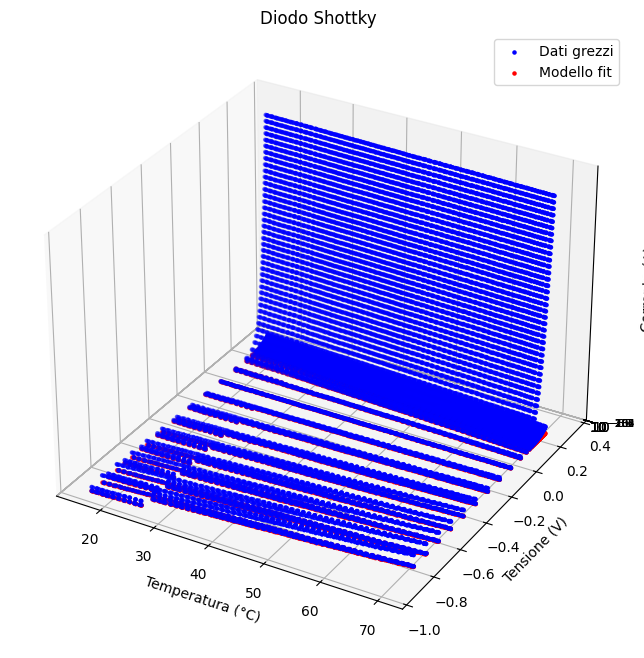

/var/folders/q8/5bxz228s2vv15c436kznwm3r0000gn/T/ipykernel_23858/590075368.py:97: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(Richardson_fit, np.vstack((V, T)), I, p0=[2.5e-3, 1.117e3, 0.7], maxfev=10000)


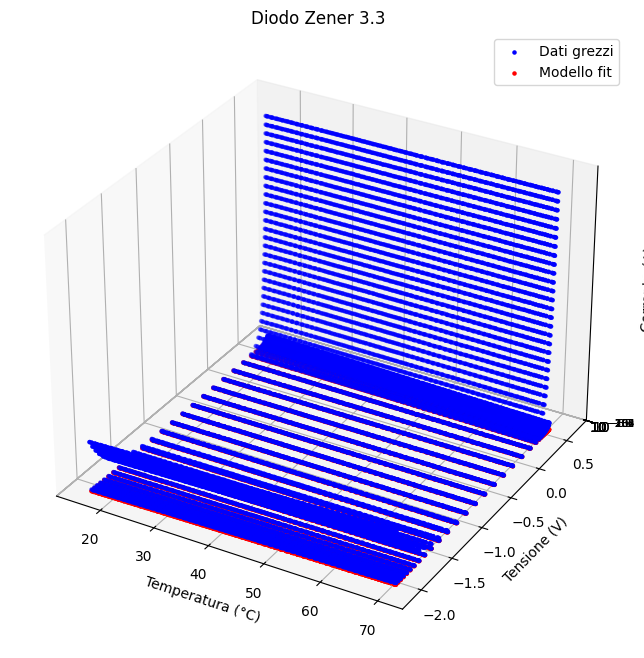

/var/folders/q8/5bxz228s2vv15c436kznwm3r0000gn/T/ipykernel_23858/590075368.py:89: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(Shockley_fit, np.vstack((V, T)), I, p0=[2.5e-3, 1.117e3, 0.7], maxfev=10000)


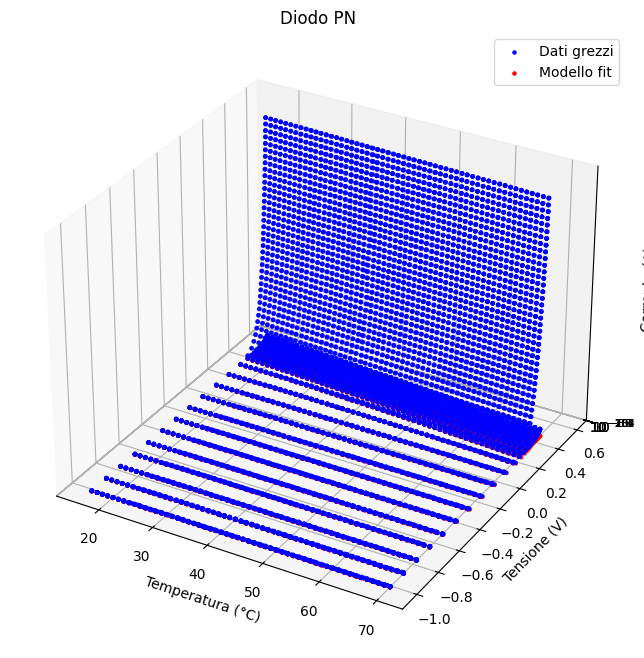

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
#%matplotlib widget

# Coppie (cartella, offset)
data_info = [
    ('Data/IV-T_dependence_20250408_110423/', [-1, 5], "Diodo Shottky"),
    ('Data/IV-T_dependence_20250408_124236/', [-3, 5], "Diodo Zener 3.3"),
    ('Data/IV-T_dependence_20250404_100546/', [-1, 5], "Diodo PN"),
]

temps = np.arange(16, 71)
pulls = np.arange(3)
flag_return_T = True

def get_filename(temp, vcc, pull, t_dir):
    t_str = 'Go' if t_dir == 1 else 'Return'
    return f"IV_T{temp:.2f}_V{vcc[0]:.2f}_{vcc[1]:.2f}_{pull}Pull_T{t_str}"

def load_data_from_folder(folder, offset):
    voltages, temperatures, currents = [], [], []
    n_directions = 2 if flag_return_T else 1

    for t_dir in range(1, n_directions + 1):
        current_temps = temps[::-1] if t_dir == 2 else temps
        for T in current_temps:
            for pull in pulls:
                fname = get_filename(T, offset, pull, t_dir) + '.txt'
                path = os.path.join(folder, fname)
                try:
                    data = np.loadtxt(path)
                    voltages.extend(data[:, 3])
                    voltages.extend(data[:, 4])
                    temperatures.extend(data[:, 0])
                    temperatures.extend(data[:, 1])
                    currents.extend(data[:, 12])
                    currents.extend(data[:, 13])
                except OSError:
                    print(f"File not found: {path}")
                    continue

    return (
        np.array(voltages),
        np.array(temperatures),
        np.abs(np.array(currents))
    )

def Shockley_fit(X, A, Eg, Vth): #Modello di Shockley
    V, T = X
    n = 2
    k = 1.380649e-23
    q = 1.602176634e-19
    T_K = T + 273.15
    Is = A * T_K**(3/2) * np.exp(-Eg / (n * k * T_K))
    return Is * (np.exp(V / (n * Vth)) - 1)

def Richardson_fit(X, A, Eg, Vth): #Modello di Richardson
    V, T = X
    k = 1.380649e-23
    q = 1.602176634e-19
    T_K = T + 273.15
    Is = A * T_K**(2) * np.exp(-Eg / (k * T_K))
    return Is * (np.exp(V/Vth) - 1)

def Zener_fit(X, A, Eg, Vth): #Modello di Zener
    V, T = X
    k = 1.380649e-23
    q = 1.602176634e-19
    T_K = T + 273.15
    Is = A * T_K**(2) * np.exp(-Eg / (k * T_K))
    return Is * (np.exp(V/Vth) - 1)

def plot_data(folder, offset, name):
    V, T, I = load_data_from_folder(folder, offset)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(T, V, I, c='b', marker='.', label='Dati grezzi')
    ax.set_zscale('log')
    ax.set_xlabel('Temperatura (°C)')
    ax.set_ylabel('Tensione (V)')
    ax.set_zlabel('Corrente (A)')
    ax.set_title(f'{name}')
    ax.grid(True)

    try:
        if name =="Diodo PN":
            popt, _ = curve_fit(Shockley_fit, np.vstack((V, T)), I, p0=[2.5e-3, 1.117e3, 0.7], maxfev=10000)
            I_fit = Shockley_fit((V, T), *popt)

        if name =="Diodo Shottky":
            popt, _ = curve_fit(Richardson_fit, np.vstack((V, T)), I, p0=[2.5e-3, 1.117e3, 0.7], maxfev=10000)
            I_fit = Richardson_fit((V, T), *popt)

        if name =="Diodo Zener 3.3":
            popt, _ = curve_fit(Richardson_fit, np.vstack((V, T)), I, p0=[2.5e-3, 1.117e3, 0.7], maxfev=10000)
            I_fit = Richardson_fit((V, T), *popt)

        ax.scatter(T, V, I_fit, c='r', marker='.', label='Modello fit')
        ax.legend()
    except RuntimeError as e:
        print(f"Fit fallito per {folder}: {e}")

    fig.set_size_inches(12, 8)
    plt.show()

# Esecuzione su ciascuna cartella
for folder, offset, name in data_info:
    plot_data(folder, offset, name)
